In [3]:
#@title Code - Load dependencies

# data
import numpy as np
import pandas as pd

# machine learning
import keras
import ml_edu.experiment

# data visualization
import plotly.express as px

In [ ]:
df = pd.read_csv('dailyboardingtotals.csv')
df['service_date'] = pd.to_datetime(df['service_date'])
df['prev_day_rides'] = df['total_rides'].shift(1)
df['prev_week_rides'] = df['total_rides'].shift(7)
df['one_year_ago_rides'] = df['total_rides'].shift(364)

# Ensure weather['datetime'] is datetime and set as index
weather = pd.read_csv('chicagoweather.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather.set_index('datetime', inplace=True)

weather['TMIN_C'] = (weather['tempmin'] - 32) * 5.0/9.0
weather['TMAX_C'] = (weather['tempmax'] - 32) * 5.0/9.0
weather['Temp (C)'] = 0.5 * (weather['TMIN_C'] + weather['TMAX_C'])
weather['PRCP_mm'] = weather['precip'] * 25.4
weather['dry day'] = (weather['PRCP_mm'] == 0).astype(int)

df = df.join(weather[['PRCP_mm', 'Temp (C)', 'dry day']])
df['annual'] = (df['service_date'] - df['service_date'].min()).dt.days / 365.

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    df[days[i]] = (df['service_date'].dt.dayofweek == i).astype(float)

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(df['service_date'].min(), df['service_date'].max())
df = df.join(pd.Series(1, index=holidays, name='holiday'))
df['holiday'].fillna(0, inplace=True)


df_base = df.loc[(df.service_date >= pd.to_datetime('2022-09-01')) & (df.service_date < pd.to_datetime('2025-01-01'))]
weather_base = weather.loc[(weather.index >= pd.to_datetime('2022-09-01')) & (weather.index < pd.to_datetime('2025-01-01'))]


/var/folders/6f/s14ngf096w3ctv98g3j3n_gr0000gn/T/ipykernel_1031/1195926788.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['holiday'].fillna(0, inplace=True)


In [18]:
merged_base = pd.merge(df_base, weather_base, left_on='service_date', right_index=True)
merged_base.head()
# order by service_date
merged_base.sort_values(by='service_date', inplace=True)
#merged_base

In [29]:
allCol = ['total_rides', 'prev_day_rides', 'prev_week_rides', 'one_year_ago_rides',
                'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'PRCP_mm_y', 'dry day_y', 'Temp (C)_y', 'annual']
training_df = merged_base.loc[merged_base.service_date < '2024-01-01', allCol]
training_df.head(200)

,total_rides,prev_day_rides,prev_week_rides,one_year_ago_rides,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,PRCP_mm_y,dry day_y,Temp (C)_y,annual
4929,897822,1440414.0,533180.0,576978.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,1,26.027778,21.679452
7722,868391,1076132.0,894924.0,1031780.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,1,26.194444,21.682192
4420,620321,1509331.0,1536825.0,1696782.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,1,26.555556,21.684932
3056,456791,1617000.0,923955.0,1098335.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.6670,0,22.277778,21.687671
1456,417557,1417033.0,563922.0,432448.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2032,0,21.222222,21.690411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,903329,984441.0,723293.0,1464776.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0000,1,2.972222,22.213699
2182,860110,1818067.0,1444630.0,689228.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.2098,0,7.305556,22.216438
3297,754616,1763599.0,962034.0,231683.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.8862,0,3.333333,22.219178
1725,483920,1708990.0,1553365.0,250502.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0000,1,-7.138889,22.221918


In [30]:
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 487




,total_rides,prev_day_rides,prev_week_rides,one_year_ago_rides,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,PRCP_mm_y,dry day_y,Temp (C)_y,annual
count,4.870000e+02,4.870000e+02,4.860000e+02,4.700000e+02,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.0,487.0000,487.000000,487.000000,487.000000
mean,7.515091e+05,1.248121e+06,1.198449e+06,1.181312e+06,0.141684,0.141684,0.141684,0.143737,0.143737,0.143737,0.143737,0.0,2.0308,0.624230,11.756331,22.345205
std,1.954619e+05,4.527525e+05,4.691886e+05,4.618329e+05,0.349084,0.349084,0.349084,0.351184,0.351184,0.351184,0.351184,0.0,6.2407,0.484819,9.771275,0.385559
min,1.405540e+05,2.328790e+05,1.744480e+05,1.601490e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,-20.416667,21.679452
25%,6.064550e+05,8.332030e+05,7.968402e+05,7.709215e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,4.222222,22.012329
50%,8.148500e+05,1.477390e+06,1.380450e+06,1.262320e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,1.000000,11.805556,22.345205
75%,9.030565e+05,1.632652e+06,1.622686e+06,1.610908e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.8128,1.000000,20.708333,22.678082
max,1.056410e+06,1.870984e+06,1.938738e+06,1.911656e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,83.2612,1.000000,31.611111,23.010959


In [31]:
#@title Code - View correlation matrix
training_df.corr(numeric_only = True)

,total_rides,prev_day_rides,prev_week_rides,one_year_ago_rides,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,PRCP_mm_y,dry day_y,Temp (C)_y,annual
total_rides,1.000000,-0.001845,0.008361,0.039629,0.040909,2.665103e-01,0.285975,0.263789,0.138451,-0.340558,-0.651529,NaN,-0.090224,0.056488,0.295261,1.765009e-01
prev_day_rides,-0.001845,1.000000,-0.005308,0.091675,0.012350,5.150554e-02,-0.005629,0.008183,0.026590,-0.078871,-0.013779,NaN,0.059822,-0.038666,-0.063476,-7.029614e-02
prev_week_rides,0.008361,-0.005308,1.000000,-0.037830,-0.001749,9.144538e-03,-0.058792,0.057561,0.009597,-0.002412,-0.013601,NaN,0.026697,-0.008559,-0.054097,1.018758e-02
one_year_ago_rides,0.039629,0.091675,-0.037830,1.000000,-0.043041,7.259650e-02,0.042584,-0.102062,0.062363,-0.063217,0.032267,NaN,-0.034864,-0.005515,0.048123,-2.123296e-02
Mon,0.040909,0.012350,-0.001749,-0.043041,1.000000,-1.650718e-01,-0.165072,-0.166463,-0.166463,-0.166463,-0.166463,NaN,-0.020074,0.035600,-0.016333,-2.890008e-03
Tue,0.266510,0.051506,0.009145,0.072596,-0.165072,1.000000e+00,-0.165072,-0.166463,-0.166463,-0.166463,-0.166463,NaN,0.016991,0.047757,0.006523,-1.912164e-16
Wed,0.285975,-0.005629,-0.058792,0.042584,-0.165072,-1.650718e-01,1.000000,-0.166463,-0.166463,-0.166463,-0.166463,NaN,0.027019,0.011284,0.016292,2.890008e-03
Thu,0.263789,0.008183,0.057561,-0.102062,-0.166463,-1.664629e-01,-0.166463,1.000000,-0.167866,-0.167866,-0.167866,NaN,-0.032949,-0.008412,0.038043,-4.371544e-03
Fri,0.138451,0.026590,0.009597,0.062363,-0.166463,-1.664629e-01,-0.166463,-0.167866,1.000000,-0.167866,-0.167866,NaN,-0.031590,-0.056753,-0.001182,-1.457181e-03
Sat,-0.340558,-0.078871,-0.002412,-0.063217,-0.166463,-1.664629e-01,-0.166463,-0.167866,-0.167866,1.000000,-0.167866,NaN,-0.034952,-0.008412,-0.019587,1.457181e-03


In [33]:
#@title Code - View pairplot
px.scatter_matrix(training_df, dimensions=allCol)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'axis': {'matches': True},
                              'label': 'total_rides',
                              'values': {'bdata': ('HrMNACdADQAhdwkAV/gGABVfBgBJkQ' ... 'Cz/wkAbNwJADhWCgCUcAgAZKwGAA=='),
                                         'dtype': 'i4'}},
                             {'axis': {'matches': True},
                              'label': 'prev_day_rides',
                              'values': {'bdata': ('AAAAAJ76NUEAAAAApGswQQAAAADTBz' ... 'AA8zM5QQAAAACMBylBAAAAAEvsOUE='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'prev_week_rides',
                              'values': {'bdata': ('AAAAAHhFIEEAAAAAmE8rQQAAAAA5cz' ... 'AAqvk4QQAAAACaxDRBAAAAAOSzHUE='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'one_year_ago_rides',
                              'values': {'bdata': ('AAAAAKSbIUEAAAAAyHwvQQAAAAAO5D' ... 'AAmEknQQAAAACU/yBBAAAAAAO4O0E='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Mon',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Tue',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Wed',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Thu',
                              'values': {'bdata': ('AAAAAAAA8D8AAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Fri',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAADwPwAAAAAAAA' ... 'AAAADwPwAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Sat',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAP' ... 'AAAAAAAAAAAAAAAPA/AAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'Sun',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAA8D8='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'holiday',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'PRCP_mm_y',
                              'values': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... '4CCYoFQAAAAAAAAAAAp1fKMsSx4j8='),
                                         'dtype': 'f8'}},
                             {'axis': {'matches': True},
                              'label': 'dry day_y',
                              'values': {'bdata': ('AQEBAAABAQEBAQAAAAEBAQEAAAAAAQ' ... 'EBAQEBAAEBAQEAAAEBAAABAAABAA=='),
           

In [34]:
#@title Code - Define ML functions

def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple linear regression model."""
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  inputs = {name: keras.Input(shape=(1,), name=name) for name in settings.input_features}
  concatenated_inputs = keras.layers.Concatenate()(list(inputs.values()))
  outputs = keras.layers.Dense(units=1)(concatenated_inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=settings.learning_rate),
                loss="mean_squared_error",
                metrics=metrics)

  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    label_name: str,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  features = {name: dataset[name].values for name in settings.input_features}
  label = dataset[label_name].values
  history = model.fit(x=features,
                      y=label,
                      batch_size=settings.batch_size,
                      epochs=settings.number_epochs)

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


^C
Note: you may need to restart the kernel to use updated packages.
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1142807724032.0000 - rmse: 1067464.0000  
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 992607862784.0000 - rmse: 996217.9375
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1014727507968.0000 - rmse: 1007178.2500
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 931464413184.0000 - rmse: 965024.0000
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 936993030144.0000 - rmse: 967881.1250  
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 934702415872.0000 - rmse: 966068.0000  
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 879892430848.0000 - rmse: 937976.8125
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 879442132992.0000 - rmse: 937595.5625
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 833457422336.0000 - rmse: 912606.1250
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

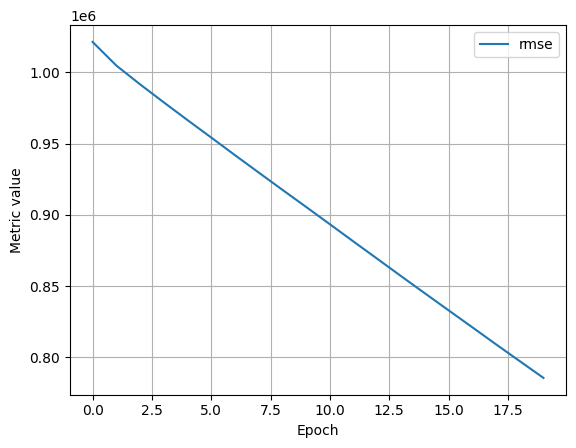

In [39]:
#@title Code - Experiment 1

%pip install nbformat

import ml_edu.results

# The following variables are the hyperparameters.
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['prev_day_rides']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_1 = create_model(settings_1, metrics)

experiment_1 = train_model('1 feature', model_1, training_df, 'total_rides', settings_1)

ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'total_rides')